In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
from functorch import make_functional, vmap, vjp, jvp, jacrev, make_functional_with_buffers
from continuum import ClassIncremental
from continuum.datasets import CIFAR10
from continuum.tasks import split_train_val
from torch.utils.data import DataLoader
import warnings
warnings.filterwarnings("ignore")
DEVICE = "cuda"

/home/zirzhang/jupyter/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(CNN, self).__init__()
        self.conv_layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(input_dim, 32, kernel_size=5),
            # torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
        )
        self.conv_layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 32, kernel_size=3),
            # torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
        )
        self.pool1 = torch.nn.MaxPool2d((2, 2), stride=(2, 2))
        self.conv_layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3),
            # torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
        )
        self.conv_layer4 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 64, kernel_size=3),
            # torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
        )
        self.layer1 = nn.Linear(64*9*9, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.pool1(x)
        x = self.conv_layer3(x)
        x = torch.flatten(self.conv_layer4(x),start_dim=1)
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.output_layer(x)
        return x

In [3]:
dataset = CIFAR10("Datasets/CIFAR10/", download=True, train=True) # Change download to True 

Files already downloaded and verified


In [4]:
scenario = ClassIncremental(
    dataset,
    increment=2,
    initial_increment=2
)
print(f"Number of classes: {scenario.nb_classes}.")
print(f"Number of tasks: {scenario.nb_tasks}.")

Number of classes: 10.
Number of tasks: 5.


In [5]:
all_datasets = dict()
for task_id, train_taskset in enumerate(scenario):
    all_datasets[task_id] = train_taskset

In [6]:
train_taskset, val_taskset = split_train_val(all_datasets[0], val_split=0.1)
train_loader = DataLoader(train_taskset, batch_size=100, shuffle=True)
val_loader = DataLoader(val_taskset, batch_size=100, shuffle=True)
all_train_loader = DataLoader(train_taskset, batch_size=10000, shuffle=True)
all_train_data = next(iter(all_train_loader))[0].to(DEVICE)
train_data_100 = next(iter(all_train_loader))[0][:10,:,:,:].to(DEVICE)

In [7]:
train_data_100.shape

torch.Size([10, 3, 32, 32])

In [8]:
net = CNN(input_dim=3, hidden_dim = 1000, output_dim=10).to(DEVICE)
fnet, params= make_functional(net)

In [9]:
def fnet_single(params, x):
    return fnet(params, x.unsqueeze(0)).squeeze(0)

In [10]:
def empirical_ntk_jacobian_contraction(fnet_single, params, x1, x2):
    # Compute J(x1)
    jac1 = vmap(jacrev(fnet_single), (None, 0))(params, x1)
    jac1 = [j.flatten(2) for j in jac1]

    # Compute J(x2)
    jac2 = vmap(jacrev(fnet_single), (None, 0))(params, x2)
    jac2 = [j.flatten(2) for j in jac2]

    # Compute J(x1) @ J(x2).T
    result = torch.stack([torch.einsum('Naf,Mbf->NMab', j1, j2) for j1, j2 in zip(jac1, jac2)])
    result = result.sum(0)
    return result

In [11]:
# result = empirical_ntk_jacobian_contraction(fnet_single, params, train_data_100, train_data_100)
# print(result.shape)

In [12]:
def empirical_ntk_jacobian_contraction(fnet_single, params, x1, x2, compute='full'):
    # Compute J(x1)
    jac1 = vmap(jacrev(fnet_single), (None, 0))(params, x1)
    jac1 = [j.flatten(2) for j in jac1]

    # Compute J(x2)
    jac2 = vmap(jacrev(fnet_single), (None, 0))(params, x2)
    jac2 = [j.flatten(2) for j in jac2]

    # Compute J(x1) @ J(x2).T
    einsum_expr = None
    if compute == 'full':
        einsum_expr = 'Naf,Mbf->NMab'
    elif compute == 'trace':
        einsum_expr = 'Naf,Maf->NM'
    elif compute == 'diagonal':
        einsum_expr = 'Naf,Maf->NMa'
    else:
        assert False

    result = torch.stack([torch.einsum(einsum_expr, j1, j2) for j1, j2 in zip(jac1, jac2)])
    result = result.sum(0)
    return result

In [13]:
result = empirical_ntk_jacobian_contraction(fnet_single, params, train_data_100, train_data_100, 'trace')
print(result.shape)

torch.Size([10, 10])


In [16]:
def cal_NTK(net, data1, data2):
    fnet, params= make_functional(net)
    result = empirical_ntk_jacobian_contraction(fnet_single, params, train_data_100, train_data_100, 'trace')
    return result

In [58]:
train_taskset, val_taskset = split_train_val(all_datasets[0], val_split=0.1)
train_loader = DataLoader(train_taskset, batch_size=100, shuffle=True)
val_loader = DataLoader(val_taskset, batch_size=100, shuffle=True)

# Hyperparameters
input_dim = 3
hidden_dim = 1000
output_dim = 10
num_epochs = 100
batch_size = 100
learning_rate = 3e-4
beta = 0.5 # KL divergence scaling factor
all_NTK_mat = torch.zeros([num_epochs,output_dim,output_dim])

# Model, optimizer, and loss function
bnn = CNN(input_dim, hidden_dim, output_dim).to(DEVICE)
optimizer = optim.Adam(bnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(num_epochs):
    bnn.train()
    for x, y, t in train_loader:
        # Forward pass
        # x_batch = torch.flatten(x,start_dim=1).to(DEVICE)
        x_batch = x.to(DEVICE)
        outputs = bnn(x_batch.to(DEVICE))
        nll_loss = criterion(outputs, y.to(DEVICE))
        
        # Backward pass
        optimizer.zero_grad()
        nll_loss.backward()
        optimizer.step()
        
    bnn.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        all_NTK_mat[epoch] = cal_NTK(bnn, train_data_100, train_data_100)
        for X_val, y_val_batch, t in val_loader:
            # X_val_batch = torch.flatten(X_val,start_dim=1).to(DEVICE)
            X_val_batch = X_val.to(DEVICE)
            val_outputs = bnn(X_val_batch)
            val_loss += criterion(val_outputs, y_val_batch.to(DEVICE)).item()
            predicted = torch.argmax(val_outputs, dim=1)  # Get predicted class
            correct += (predicted == y_val_batch.to(DEVICE)).sum().item()
            total += y_val_batch.size(0)

    val_accuracy = correct / total * 100
        
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {nll_loss.item():.4f}, Val Loss: {val_loss:.4f}, Val accuracy: {val_accuracy:.2f}%")

print("Training complete!")

Epoch [1/100], Train Loss: 0.4248, Val Loss: 4.3814, Val accuracy: 81.70%
Epoch [2/100], Train Loss: 0.3317, Val Loss: 2.8001, Val accuracy: 87.60%
Epoch [3/100], Train Loss: 0.2183, Val Loss: 2.5104, Val accuracy: 90.70%
Epoch [4/100], Train Loss: 0.1742, Val Loss: 1.9997, Val accuracy: 92.10%
Epoch [5/100], Train Loss: 0.2998, Val Loss: 1.9811, Val accuracy: 91.70%
Epoch [6/100], Train Loss: 0.1622, Val Loss: 2.3829, Val accuracy: 90.60%
Epoch [7/100], Train Loss: 0.1597, Val Loss: 1.6841, Val accuracy: 93.20%
Epoch [8/100], Train Loss: 0.1151, Val Loss: 1.7546, Val accuracy: 93.20%
Epoch [9/100], Train Loss: 0.1614, Val Loss: 2.4123, Val accuracy: 91.50%
Epoch [10/100], Train Loss: 0.1595, Val Loss: 1.8433, Val accuracy: 93.00%
Epoch [11/100], Train Loss: 0.0357, Val Loss: 1.7808, Val accuracy: 93.70%
Epoch [12/100], Train Loss: 0.0838, Val Loss: 1.8898, Val accuracy: 93.60%
Epoch [13/100], Train Loss: 0.0503, Val Loss: 1.9892, Val accuracy: 94.10%
Epoch [14/100], Train Loss: 0.0400

In [59]:
all_NTK_mat.shape

torch.Size([100, 10, 10])

In [60]:
a = torch.linalg.eigvals(all_NTK_mat)

In [61]:
max_eig = []
min_eig = []
for i in range(all_NTK_mat.shape[0]):
    max_eig.append(abs(a[i][0].item()))
    min_eig.append(abs(a[i][-1].item()))

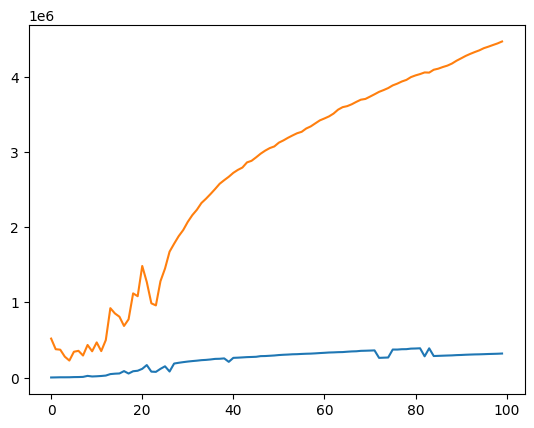

In [62]:
import matplotlib.pyplot as plt
plt.plot(min_eig)
plt.plot(max_eig)